# Lab 9: Two-Player Competitive Games

We will use an open-source library called [OpenSpiel](https://github.com/deepmind/open_spiel), which has implementation of a number of games.

In [1]:
# *Important*:
# This takes a while: ~10min, so it's better to do before the lab starts.
#
# Currently, it prints some errors about dependency versions, but those 
# packages are not relevant to what we will use in the lab, so it is ok.
!pip install open_spiel

  Obtaining dependency information for open_spiel from https://files.pythonhosted.org/packages/8d/06/4c5087879a4a5b1ae0719fb50af28a63a3fee39b2ea072e315a91e5040cc/open_spiel-1.5-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for absl-py>=0.10.0 from https://files.pythonhosted.org/packages/f6/d4/349f7f4bd5ea92dab34f5bb0fe31775ef6c311427a14d5a5b31ecb442341/absl_py-2.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for scipy>=1.10.1 from https://files.pythonhosted.org/packages/c0/53/eaada1a414c026673eb983f8b4a55fe5eb172725d33d62c1b21f63ff6ca4/scipy-1.15.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
  Obtaining dependency information for ml-collections>=0.1.1 from https://files.pythonhosted.org/packages/ab/8a/18d4ff2c7bd83f30d6924bd4ad97abf418488c3f908dea228d6f0961ad68/ml_collections-1.1.0-py3-none-any.whl.metadata
  

In [2]:
# Let's make some imports
from typing import Callable, Dict, List, Tuple, Union
import functools

import numpy as np
import pyspiel

In [3]:
# Let's see what game implementations are available in the library:
for game_type in pyspiel.registered_games():
  if     game_type.information == pyspiel.GameType.Information.PERFECT_INFORMATION \
     and game_type.chance_mode == pyspiel.GameType.ChanceMode.DETERMINISTIC \
     and game_type.dynamics    == pyspiel.GameType.Dynamics.SEQUENTIAL \
     and game_type.utility     == pyspiel.GameType.Utility.ZERO_SUM \
     and game_type.min_num_players == 2 \
     and game_type.max_num_players == 2:
    print(game_type.short_name)

amazons
breakthrough
checkers
chess
clobber
connect_four
cursor_go
dots_and_boxes
go
havannah
hex
mancala
nim
nine_mens_morris
othello
oware
pentago
tic_tac_toe
twixt
ultimate_tic_tac_toe
y


In [4]:
# Example playthrough of tic-tac-toe.

game = pyspiel.load_game("tic_tac_toe")
state = game.new_initial_state()
print(str(state) + '\n')

while not state.is_terminal():
  state.apply_action(np.random.choice(state.legal_actions()))
  print(str(state) + '\n')

print(state.rewards())

...
...
...

..x
...
...

..x
...
..o

..x
..x
..o

o.x
..x
..o

oxx
..x
..o

oxx
..x
o.o

oxx
x.x
o.o

oxx
x.x
ooo

[-1.0, 1.0]


 **Question**: How many nodes are there in the game tree of Tic-Tac-Toe?
 


**Question**: What is the game value of Tic-Tac-Toe?



In [5]:
# Some helper functions we will use later. 

def state_str_printer(state: pyspiel.State) -> None:
  print(str(state) + '\n')

def play(game_or_name: Union[str, pyspiel.Game], player_fns: List[Callable[[pyspiel.State], int]], 
    state_printer: Callable[[pyspiel.State], None] = state_str_printer) -> None:
  if isinstance(game_or_name, str): 
    game = pyspiel.load_game(game_or_name)
  else: 
    assert(isinstance(game_or_name, pyspiel.Game))
    game = game_or_name

  state = game.new_initial_state()
  state_printer(state)

  while not state.is_terminal():
    action = player_fns[state.current_player()](state)
    state.apply_action(action)
    state_printer(state)
  
  print("Game over: ", state.rewards())

def human_player(state: pyspiel.State) -> int:
  while True:
    print("Choose action. One of: ", [state.action_to_string(action) 
                                      for action in state.legal_actions()])
    action_str = input()
    try:
      action = state.string_to_action(action_str)
      if action in state.legal_actions():
        return action
      else: 
        raise ValueError()
    except Exception:
      print("Illegal action. Try again.")


def random_player(state: pyspiel.State) -> int:
  return np.random.choice(state.legal_actions())

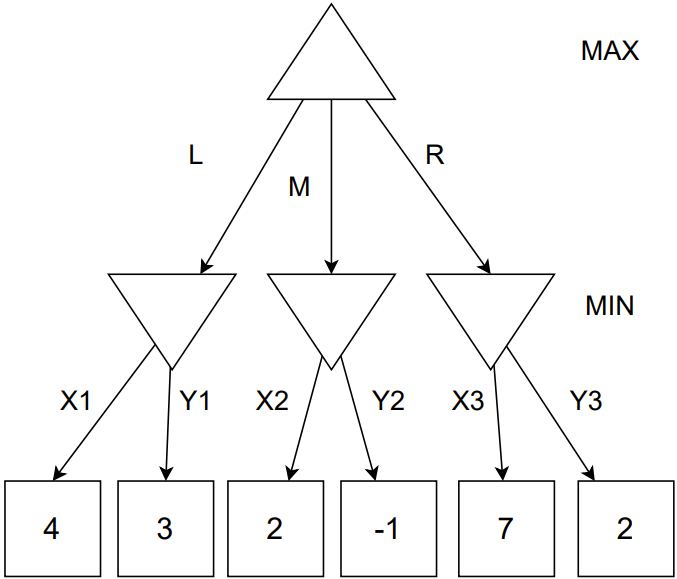

In [6]:
# Let's recreate the game from the lectures:
# The format is unimportant, it encodes the game above ^^^.

lecture_game = pyspiel.load_efg_game("""
    EFG 2 R "Problem from the lecture" { "Player 1" "Player 2" } ""
 
    p "" 1 1 "∅"    { "L" "M" "R" } 0
    p "" 2 1 "L"    { "X1" "Y1" }   0
    t ""   1 "L X1" { 4.0 -4.0 } 
    t ""   2 "L Y1" { 3.0 -3.0 }
    p "" 2 2 "M"    { "X2" "Y2" }   0
    t ""   3 "M X2" {  2.0 -2.0 } 
    t ""   4 "M Y2" { -1.0  1.0 } 
    p "" 2 3 "R"    { "X3" "Y3" }   0
    t ""   5 "R X3" { 7.0 -7.0 }
    t ""   6 "R Y3" { 2.0 -2.0 }
""")
 
play(lecture_game, [random_player, random_player])

0: Player:  1 1 ∅ L M R


2: Player:  2 2 M X2 Y2


7: Terminal:  M Y2 -1 1


Game over:  [-1.0, 1.0]


## MiniMax

The main idea of the Minimax is that the first player is trying to maximize and second to minimize. So the first player always picks action that he expects to get him the most, while the second player always picks action that gives him the least. Furthermore, both players assume their opponent has the same decision process.
Similarly to deterministic uninformed search, we can use a depth-first search algorithm to find best action and it's expected value.

For a history h:

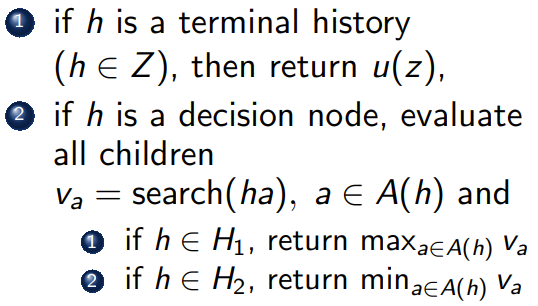

In [33]:
def minimax(state: pyspiel.State,
            maximizing_player: int) -> Tuple[float, int, int]:
  # Return tuple of: node value, best action, visit count
  # Hints: 
  # - use state.legal_actions(), state.apply_action(action)
  # - use state.clone() when recursing to child states.
  # - use float("inf") and -float("inf") to initialize values.

  if state.is_terminal():
    return state.rewards()[maximizing_player], None, 1

  best_action = -1
  visit_count = 1

  if state.current_player() == maximizing_player:
      value = float("-inf")
      for action in state.legal_actions():
          state_clone = state.clone()
          state_clone.apply_action(action)
          new_value, _, new_visit_count = minimax(state_clone, maximizing_player)
          visit_count += new_visit_count
          if new_value > value:
              value = new_value
              best_action = action
  else:
      value = float("inf")
      for action in state.legal_actions():
          state_clone = state.clone()
          state_clone.apply_action(action)
          new_value, _, new_visit_count = minimax(state_clone, maximizing_player)
          visit_count += new_visit_count
          if new_value < value:
              value = new_value
              best_action = action

  return value, best_action, visit_count

Let's compute the value of the game from the lecture:

In [39]:
game_value, best_action, visit_count = minimax(lecture_game.new_initial_state(),
                                               maximizing_player=0)
print(game_value, 
      best_action, 
      visit_count)

3.0 0 10


In [40]:
def full_minimax_player(state: pyspiel.State, player: int) -> int:
  value, action, visit_count = minimax(state, player)
  print("Visited", visit_count, "nodes")
  return action

In [41]:
play("tic_tac_toe", [functools.partial(full_minimax_player, player=0), 
                     functools.partial(full_minimax_player, player=1)])

...
...
...

Visited 549946 nodes
x..
...
...

Visited 59705 nodes
x..
.o.
...

Visited 7332 nodes
xx.
.o.
...

Visited 935 nodes
xxo
.o.
...

Visited 198 nodes
xxo
.o.
x..

Visited 47 nodes
xxo
oo.
x..

Visited 14 nodes
xxo
oox
x..

Visited 5 nodes
xxo
oox
xo.

Visited 2 nodes
xxo
oox
xox

Game over:  [0.0, 0.0]


**Question**: What is the number of nodes in the game tree?



**Question**: How can we make the algorithm more efficient?



In [ ]:
# We can play against our algorithm!

# play("tic_tac_toe", [functools.partial(full_minimax_player, player=0), human_player])


# Alpha-Beta pruning

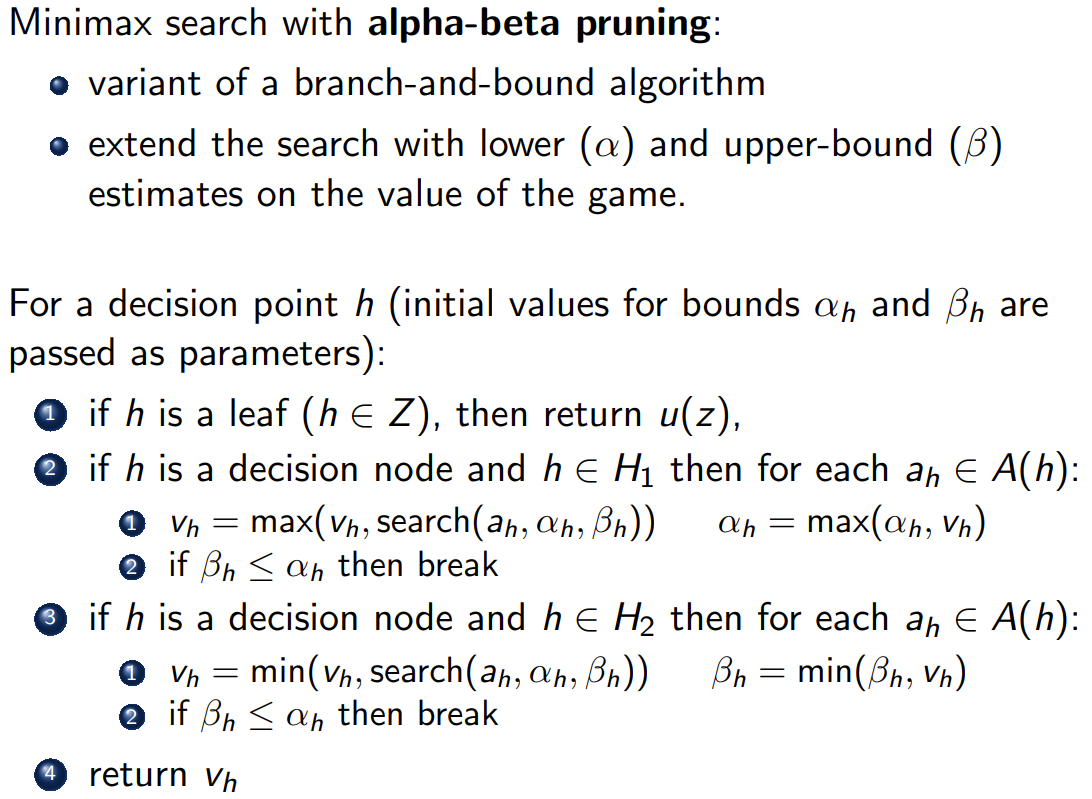

*Perform the alpha-beta manually on the table, with the game from minimax example.*



In [42]:
def alpha_beta(state: pyspiel.State,
               alpha: float,
               beta: float,
               maximizing_player: int) -> Tuple[float, int, int]:
  # Return tuple of: node value, best action, visit count
  # Hints: 
  # - reuse the implementation of minimax and only add the cut-offs
  # - use state.legal_actions(), state.apply_action(action)
  # - use state.clone() when recursing to child states.
  # - use float("inf") and -float("inf") to initialize values.
 
  if state.is_terminal():
    return state.rewards()[maximizing_player], None, 1

  best_action = -1
  visit_count = 1

  if state.current_player() == maximizing_player:
      value = float("-inf")
      for action in state.legal_actions():
          state_clone = state.clone()
          state_clone.apply_action(action)
          new_value, _, new_visit_count = alpha_beta(state_clone, alpha, beta, maximizing_player)
          visit_count += new_visit_count
          if new_value > value:
              value = new_value
              best_action = action

          alpha = max(alpha, new_value)
          if beta <= alpha: break
  else:
      value = float("inf")
      for action in state.legal_actions():
          state_clone = state.clone()
          state_clone.apply_action(action)
          new_value, _, new_visit_count = alpha_beta(state_clone, alpha, beta, maximizing_player)
          visit_count += new_visit_count
          if new_value < value:
              value = new_value
              best_action = action

          beta = min(beta, new_value)
          if beta <= alpha: break

  return value, best_action, visit_count

In [43]:
# Alpha-Beta without a value function -- full tree traversal.

def alpha_beta_player(state: pyspiel.State, player: int) -> int:
  value, action, visit_count = alpha_beta(state,
                                          alpha=-float("inf"),
                                          beta=float("inf"),
                                          maximizing_player=player)
  print("Visited", visit_count, "states")
  return action

In [44]:
play("tic_tac_toe", [functools.partial(alpha_beta_player, player=0), 
                     functools.partial(alpha_beta_player, player=1)])

...
...
...

Visited 18297 states
x..
...
...

Visited 2338 states
x..
.o.
...

Visited 844 states
xx.
.o.
...

Visited 75 states
xxo
.o.
...

Visited 64 states
xxo
.o.
x..

Visited 17 states
xxo
oo.
x..

Visited 10 states
xxo
oox
x..

Visited 5 states
xxo
oox
xo.

Visited 2 states
xxo
oox
xox

Game over:  [0.0, 0.0]


**Question** Compare the number of visited nodes in the first round.



## BONUS: NegaScout

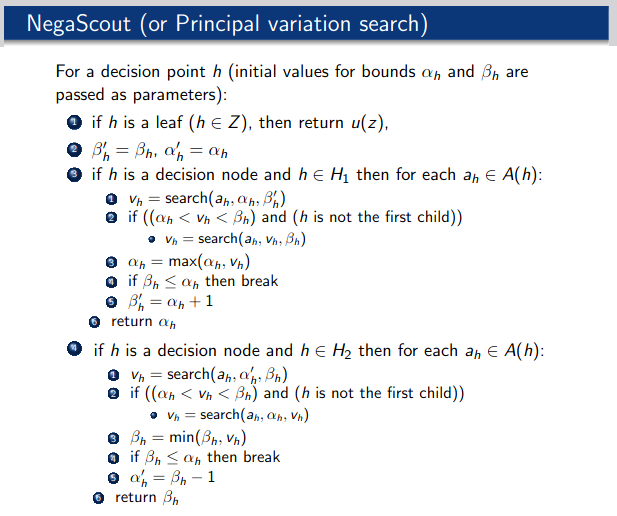


*Perform the Negascout manually on the table, with the game from minimax example.*



In [ ]:
def nega_scout(state: pyspiel.State,
               alpha: float,
               beta: float,
               maximizing_player: int) -> Tuple[float, int, int]:
  # Return tuple of: node value, best action, visit count
  # Hints: 
  # - reuse the implementation of alpha-beta and only add the temporary bounds and re-search
  # - use state.legal_actions(), state.apply_action(action)
  # - use state.clone() when recursing to child states.
  # - use float("inf") and -float("inf") to initialize values.

 
  if state.is_terminal():
    return state.rewards()[maximizing_player], None, 1

  best_action = -1
  visit_count = 1

  new_beta = beta
  new_alpha = alpha

  if state.current_player() == maximizing_player:
      value = float("-inf")
      for action in state.legal_actions():
          state_clone = state.clone()
          state_clone.apply_action(action)
          new_value, _, new_visit_count = nega_scout(state_clone, alpha, new_beta, maximizing_player)
          if alpha < new_value and new_value < beta:
              new_value, _, new_new_visit_count = nega_scout(state_clone, new_value, beta, maximizing_player)
              visit_count += new_new_visit_count
          visit_count += new_visit_count

          alpha = max(alpha, new_value)
          if beta <= alpha: break

          new_beta = alpha + 1
      return alpha
  else:
      value = float("inf")
      for action in state.legal_actions():
          state_clone = state.clone()
          state_clone.apply_action(action)
          new_value, _, new_visit_count = alpha_beta(state_clone, alpha, beta, maximizing_player)
          visit_count += new_visit_count
          if new_value < value:
              value = new_value
              best_action = action

          beta = min(beta, new_value)
          if beta <= alpha: break

  return value, best_action, visit_count



In [ ]:
# NegaScout

def nega_scout_player(state: pyspiel.State, player: int) -> int:
  value, action, visit_count = nega_scout(state,
                                          alpha=-float("inf"),
                                          beta=float("inf"),
                                          maximizing_player=player)
  print("Visited", visit_count, "states")
  return action

In [ ]:
play("tic_tac_toe", [functools.partial(nega_scout_player, player=0), 
                     functools.partial(nega_scout_player, player=1)])